In [2]:
import os
import json
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp

from SALib import ProblemSpec

from water_balance_jax import wbm_jax

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50
plt.rcParams["font.size"] = 10

In [9]:
#####################
#### Directories ####
#####################
nldas_path = '/storage/group/pches/default/public/NLDAS/'
smap_path = '/storage/group/pches/default/public/SMAP/'
project_code_path = '/storage/home/dcl5300/work/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/'
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

In [4]:
###########################
# Kc timeseries function
###########################
def construct_Kpet(GS_start, GS_length, L_ini, L_dev, L_mid, L_late, Kc_ini, Kc_mid, Kc_end, K_min, K_max, lai):
    # Out
    Kpet_out = np.empty(365)

    # Get days from relative length
    doy_ini = int(L_ini * GS_length)
    doy_dev = int(L_dev * GS_length)
    doy_mid = int(L_mid * GS_length)
    doy_late = int(L_late * GS_length)

    # Transition phases
    Kc_dev = np.linspace(Kc_ini, Kc_mid, doy_dev)
    Kc_down = np.linspace(Kc_mid, Kc_end, doy_late)
    
    # Loop through year
    for doy in range(365):
        if doy < GS_start:
            Kpet_out[doy] = K_min + (K_max - K_min) * (1 - np.exp(-0.7*lai[doy]))
        elif doy < (GS_start + doy_ini):
            Kpet_out[doy] = Kc_ini
        elif doy < (GS_start + doy_ini + doy_dev):
            Kpet_out[doy] = Kc_dev[doy - (GS_start + doy_ini)]
        elif doy < (GS_start + doy_ini + doy_dev + doy_mid):
            Kpet_out[doy] = Kc_mid
        elif doy < (GS_start + doy_ini + doy_dev + doy_mid + doy_late):
            Kpet_out[doy] = Kc_down[doy - (GS_start + doy_ini + doy_dev + doy_mid)]
        else:
            Kpet_out[doy] = K_min + (K_max - K_min) * (1 - np.exp(-0.7*lai[doy]))

    return Kpet_out

In [6]:
def store_params(param_dict, N, experiment_name):
    #########################
    # Problem spec for SAlib
    #########################
    param_names = list(param_dict.keys())
    n_params = len(param_names)

    # Check if done
    if not os.path.isfile(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt"):
        sp = ProblemSpec({
            'num_vars': n_params,
            'names': param_names,
            'bounds': [param_dict[param] for param in param_names]
        }).sample_sobol(N)
    
        np.savetxt(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt", sp.samples)
    else:
        print('Parameter file already exists!')

In [7]:
def wbm_sa(ix, iy, forcing, eval, tas_delta, prcp_factor, experiment_name, N, save_name):
    """
    Perform a single gridpoint Sobol SA using parameter file in `experiment_name`.
        - ix, iy assuming CONUS (whole domain)
        - Metrics include mean, SD, range, and RMSE against obs if `eval` = NLDAS, SMAP
        - CC can be imposed by `tas_delta` and `prcp_factor`
    """
    ##################
    # Get forcing
    ##################
    # Read data
    if forcing == "SMAP":
        forcing_data = np.load(f'{project_data_path}/WBM/precalibration/CONUS/{forcing}/inputs.npz')
    else:
        forcing_data = np.load(f'{project_data_path}/WBM/precalibration/CONUS/VIC/inputs.npz') # identical for SA purposes

    # Select gridpoint
    tas_in = forcing_data['tas'][ix, iy, :]
    prcp_in = forcing_data['prcp'][ix, iy, :]
    lai_in = forcing_data['lai'][ix, iy, :]
    phi = forcing_data['lats'][iy]
    
    ###################
    # Get observations
    ###################
    if eval == 'SMAP':
        obs = np.load(f'{project_data_path}/WBM/precalibration/CONUS/{forcing}/{forcing}_validation.npy')
        obs = obs[ix, iy, :]
        obs_centered = obs - jnp.mean(obs)
    elif eval == "NLDAS":
        obs_list = ['VIC', 'NOAH', 'MOSAIC']
        obs = [np.load(f'{project_data_path}/WBM/precalibration/CONUS/{obs}/{obs}_validation.npy') for obs in obs_list]
        obs = [obs_tmp[ix, iy, :] for obs_tmp in obs]
        obs_centered = [obs_tmp - jnp.mean(obs_tmp) for obs_tmp in obs]
    
    ################
    # Get params
    ################
    params = np.loadtxt(f"{project_data_path}/WBM/SA/{experiment_name}_{str(N)}_params.txt", float)
    n_params = len(params)

    ####################
    # Loop through all
    ####################
    out_mean = np.zeros(n_params)
    out_sd = np.zeros(n_params)
    out_range = np.zeros(n_params)
    if eval == "SMAP":
        out_rmse = np.zeros(n_params)
        out_ubrmse = np.zeros(n_params)
    elif eval == "NLDAS":
        out_rmse = [np.zeros(n_params) for _ in range(3)]
        out_ubrmse = [np.zeros(n_params) for _ in range(3)]
    
    for iparam in range(n_params):
        # Read in correct order!
        Ts = params[iparam][0]
        Tm = params[iparam][1]
        wiltingp = params[iparam][2]
        awCap = params[iparam][3]
        alpha = params[iparam][4]
        betaHBV = params[iparam][5]
        GS_start = int(params[iparam][6])
        GS_length = int(params[iparam][7])
        L_ini = params[iparam][8]
        L_dev = params[iparam][9]
        L_mid = params[iparam][10]
        L_late = 1. - (L_ini + L_dev + L_mid)
        Kc_ini = params[iparam][11]
        Kc_mid = params[iparam][12]
        Kc_end = params[iparam][13]
        K_min = params[iparam][14]
        K_max = params[iparam][15]
    
        # Construct Kc timeseries
        Kpet_in = construct_Kpet(GS_start, GS_length, L_ini, L_dev, L_mid, L_late, Kc_ini, Kc_mid, Kc_end, K_min, K_max, lai_in)
    
        # Initial conditions
        Ws_init = awCap / 2.0 # Initial soil moisture
        Wi_init = 0.0 # Canopy water storage
        Sp_init = 0.0 # Snowpack
    
        # Run it
        out = wbm_jax(
            tas=tas_in + tas_delta,
            prcp=prcp_in * prcp_factor,
            Kpet=Kpet_in,
            Ws_init=Ws_init,
            Wi_init=Wi_init,
            Sp_init=Sp_init,
            lai=lai_in,
            phi=phi,
            params=(Ts, Tm, wiltingp, awCap, alpha, betaHBV),
        )
    
        # Store metrics
        out_mean[iparam] = jnp.mean(out)
        out_sd[iparam] = jnp.std(out)
        out_range[iparam] = jnp.max(out) - jnp.min(out)

        out_centered = out - jnp.mean(out)
        if eval == "SMAP":
            out_rmse[iparam] = jnp.sqrt(jnp.mean((out - obs)**2))
            out_ubrmse[iparam] = jnp.sqrt(jnp.mean((out_centered - obs_centered)**2))
        elif eval == "NLDAS":
            for io in range(len(obs_list)):
                out_rmse[io][iparam] = jnp.sqrt(jnp.mean((out - obs[io])**2))
                out_ubrmse[io][iparam] = jnp.sqrt(jnp.mean((out_centered - obs_centered[io])**2))

    ####################
    # Calculate indices
    ####################
    # Problem spec
    with open(f"{project_data_path}/WBM/SA/{experiment_name}.json") as f:
        params_dict = json.load(f)

    param_names = list(params_dict.keys())
    sp = ProblemSpec({
        'num_vars': n_params,
        'names': param_names,
        'bounds': [params_dict[param] for param in param_names]
    }).set_samples(params);

    # Analyze all
    df_out = []

    # Set up list
    if eval == "SMAP":
        metrics = [out_mean, out_sd, out_range, out_rmse, out_ubrmse]
        metric_names = ['mean', 'sd', 'range', 'rmse', 'ubrmse']
    elif eval == "NLDAS":
        metrics = [out_mean, out_sd, out_range] + [out for out in out_rmse] + [out for out in out_ubrmse]
        metric_names = ['mean', 'sd', 'range'] + [f'rmse_{obs}' for obs in obs_list] + [f'ubrmse_{obs}' for obs in obs_list]
    else:
        metrics = [out_mean, out_sd, out_range]
        metric_names = ['mean', 'sd', 'range']

    # Loop and calculate
    for metric, metric_name in zip(metrics, metric_names):
        # Calculate
        sp.set_results(metric);
        sp.analyze_sobol();
        # Store
        total, first, second = sp.to_df()
        df_tmp = pd.merge(total, first, left_index=True, right_index=True)
        df_tmp['metric'] = metric_name
        df_out.append(df_tmp.reset_index().rename(columns={'index':'param'}))

    # Save
    df_out = pd.concat(df_out)
    df_out.to_csv(f"{project_data_path}/WBM/SA/{save_name}_res.csv", index=False)

# Experiments

## Champaign IL maize

### Compute

In [7]:
# Uncertain parameters
experiment_name = "champaign_IL_maize"

param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
# NOAH wiltingp: ~90mm, MOSAIC: ~170
param_dict['wiltingp'] = [50, 400] # Wilting point [mm]
# UC Davis awCap: ~250mm
param_dict['awCap'] = [100, 400] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize)
param_dict['GS_start'] = [90, 120] # April or May
param_dict['GS_length'] = [180, 240] # 6-8 months
param_dict['L_ini'] = [0.12, 0.22] # +/- 0.5 from Siebert and Doll
param_dict['L_dev'] = [0.23, 0.33] # +/- 0.5 from Siebert and Doll
param_dict['L_mid'] = [0.28, 0.38] # +/- 0.5 from Siebert and Doll
param_dict['Kc_ini'] = [0.1, 0.7] # +/- 0.2 from Siebert and Doll
param_dict['Kc_mid'] = [1., 1.4] # +/- 0.2 from Siebert and Doll
param_dict['Kc_end'] = [0.2, 0.6] # +/- 0.2 from Siebert and Doll
param_dict['K_min'] = param_dict['Kc_ini']
param_dict['K_max'] = param_dict['Kc_mid']

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

Parameter file already exists!
Parameter file already exists!
Parameter file already exists!


In [8]:
# Get lat, lon of Champaign county location
lats = np.load(f'{project_data_path}/WBM/precalibration/CONUS/SMAP/inputs.npz')['lats']
lons = np.load(f'{project_data_path}/WBM/precalibration/CONUS/SMAP/inputs.npz')['lons']

# Choose location
lat, lon = 40.07048942363884, -88.34859438003343

# Get indices
ix = (np.abs(lons - lon)).argmin()
print(ix)
iy = (np.abs(lats - lat)).argmin()
print(iy)

293
120


In [9]:
%%time
# RUN IT
experiment_name = "champaign_IL_maize"

# Historical
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sa(ix=ix, iy=iy,
                   forcing=obs, eval=obs,
                   tas_delta=0., prcp_factor=1.,
                   experiment_name=experiment_name,
                   N=N,
                   save_name=save_name)
            print(save_name)

# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sa(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           N=N,
                           save_name=save_name)
                    print(save_name)

champaign_IL_maize_1024_SMAP_noCC already done
champaign_IL_maize_2048_SMAP_noCC already done
champaign_IL_maize_4096_SMAP_noCC already done
champaign_IL_maize_1024_NLDAS_noCC already done
champaign_IL_maize_2048_NLDAS_noCC already done
champaign_IL_maize_4096_NLDAS_noCC already done
champaign_IL_maize_1024_SMAP_CCtas-5prcp0.5 already done
champaign_IL_maize_1024_SMAP_CCtas-5prcp0.9 already done
champaign_IL_maize_1024_SMAP_CCtas-5prcp1.1 already done
champaign_IL_maize_1024_SMAP_CCtas-5prcp1.5 already done
champaign_IL_maize_1024_SMAP_CCtas1prcp0.5 already done
champaign_IL_maize_1024_SMAP_CCtas1prcp0.9 already done
champaign_IL_maize_1024_SMAP_CCtas1prcp1.1 already done
champaign_IL_maize_1024_SMAP_CCtas1prcp1.5 already done
champaign_IL_maize_1024_SMAP_CCtas5prcp0.5 already done
champaign_IL_maize_1024_SMAP_CCtas5prcp0.9 already done
champaign_IL_maize_1024_SMAP_CCtas5prcp1.1 already done
champaign_IL_maize_1024_SMAP_CCtas5prcp1.5 already done
champaign_IL_maize_1024_SMAP_CCtas10prc

### Plots

In [12]:
# Plotting function: hist
def make_hist_plot(obs, experiment, save_name):
    # Historical
    df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs}_noCC_res.csv')
    df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_{obs}_noCC_res.csv')
    df_N4096 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs}_noCC_res.csv')

    # Get params
    params = df_N1024['param'].unique()
    n_params = len(params)

    # Get metrics 
    metrics = df_N1024.metric.unique()

    ######### Plot
    fig, axs = plt.subplots(nrows=int(np.ceil(len(metrics)/3)), ncols=3,
                            figsize=(15,int(np.ceil(len(metrics)/3))*3),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.8))
    axs = axs.flatten()

    # Loop through all
    for ix, metric in enumerate(metrics):
        for id, data in enumerate([df_N1024, df_N2048, df_N4096]):
            axs[ix].bar(x=np.arange(id, (n_params*4) + id, 4),
                        height=data[data.metric == metric]['ST'],
                        yerr=data[data.metric == metric]['ST_conf'],
                        color=f'C{id}')

        # Tidy
        axs[ix].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
        axs[ix].set_title(metric)
        axs[ix].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(obs, y=0.95, fontweight='bold')

    # Remove unused axes
    unused = int(np.ceil(len(metrics)/3))*3 - len(metrics)
    if unused > 0:
        for ix in range(1,unused+1):
            axs[-ix].axis('off')

    if save_name:
        plt.savefig(f"{project_code_path}/figs/{save_name}.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

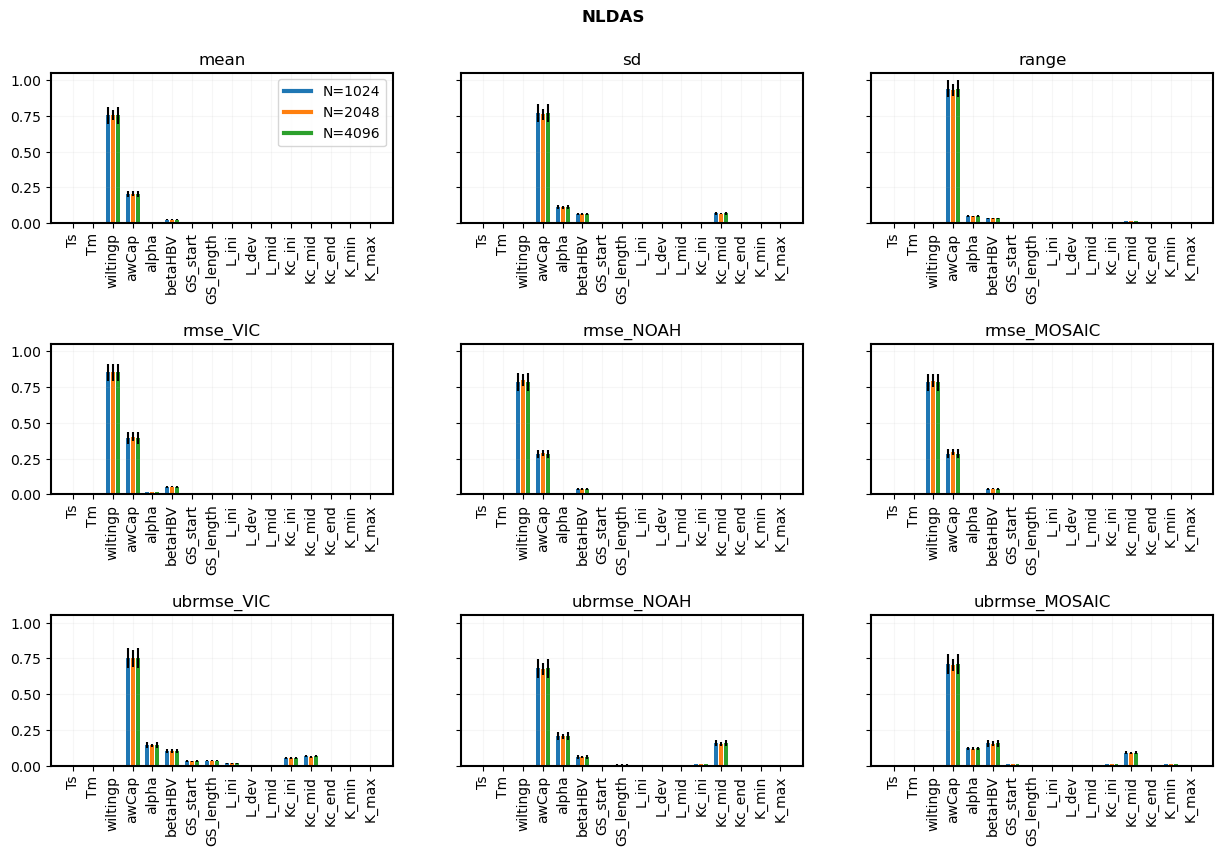

In [13]:
obs = "NLDAS"
experiment = "champaign_IL_maize"
save_name = "champaign_IL_maize_NLDAS_hist"

make_hist_plot(obs, experiment, save_name)

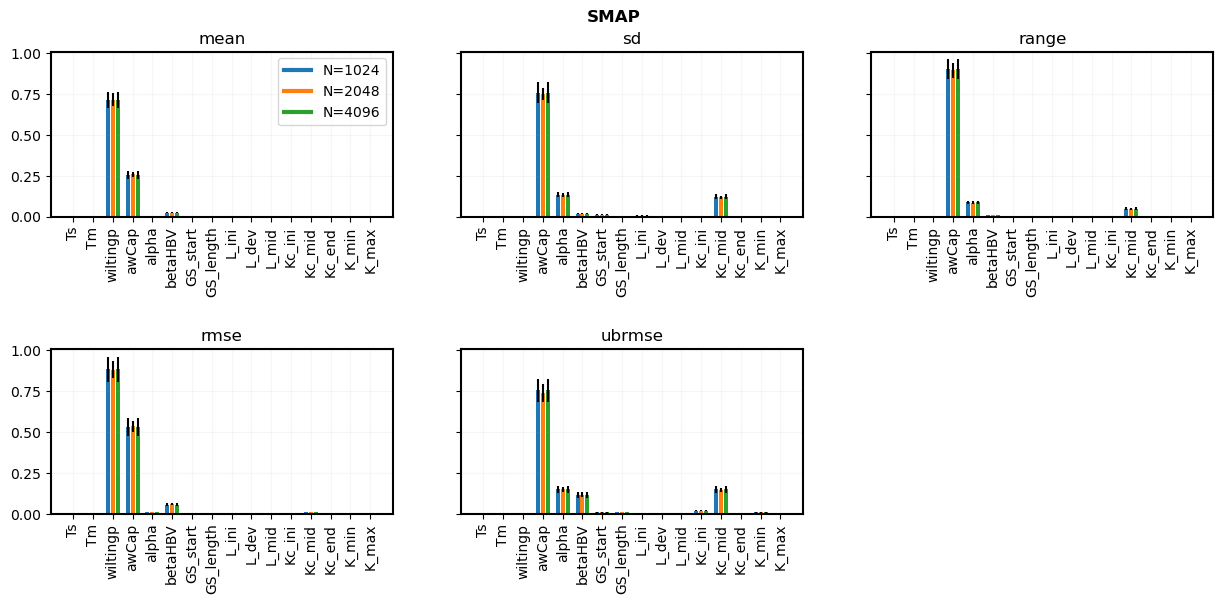

In [14]:
obs = "SMAP"
experiment = "champaign_IL_maize"
save_name = "champaign_IL_maize_SMAP_hist"

make_hist_plot(obs, experiment, save_name)

In [31]:
# Plotting function: future
def make_future_plot(obs, metric, experiment):
    # Read CC realizations
    data_all = {}
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = pd.read_csv(f"{project_data_path}/WBM/SA/{experiment}_{read_name}_res.csv")
                data_all[read_name] = df

    # Get params
    params = data_all[read_name]['param'].unique()
    n_params = len(params)

    ######### Plot
    fig, axs = plt.subplots(nrows=4, ncols=4,
                            figsize=(15,14),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.75))

    # Loop through all
    for ixt, tas_delta in enumerate([-5, 1, 5, 10]):
        for ixp, prcp_factor in enumerate([0.5, 0.9, 1.1, 1.5]):
            for ixn, N in enumerate([1024, 2048, 4096]):
                # Grab df
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = data_all[read_name]
                
                # Plot
                axs[ixt, ixp].bar(x=np.arange(ixn, (n_params*4) + ixn, 4),
                                  height=df[df.metric == metric]['ST'],
                                  yerr=df[df.metric == metric]['ST_conf'],
                                  color=f'C{ixn}')

            # Tidy
            axs[ixt, ixp].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
            axs[ixt, ixp].set_title(f'tas delta: {str(tas_delta)}C, prcp factor: {str(prcp_factor)}')
            axs[ixt, ixp].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0,0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(f"Perturbed {obs} forcing; {metric}", y=0.92, fontweight='bold')

    plt.show()

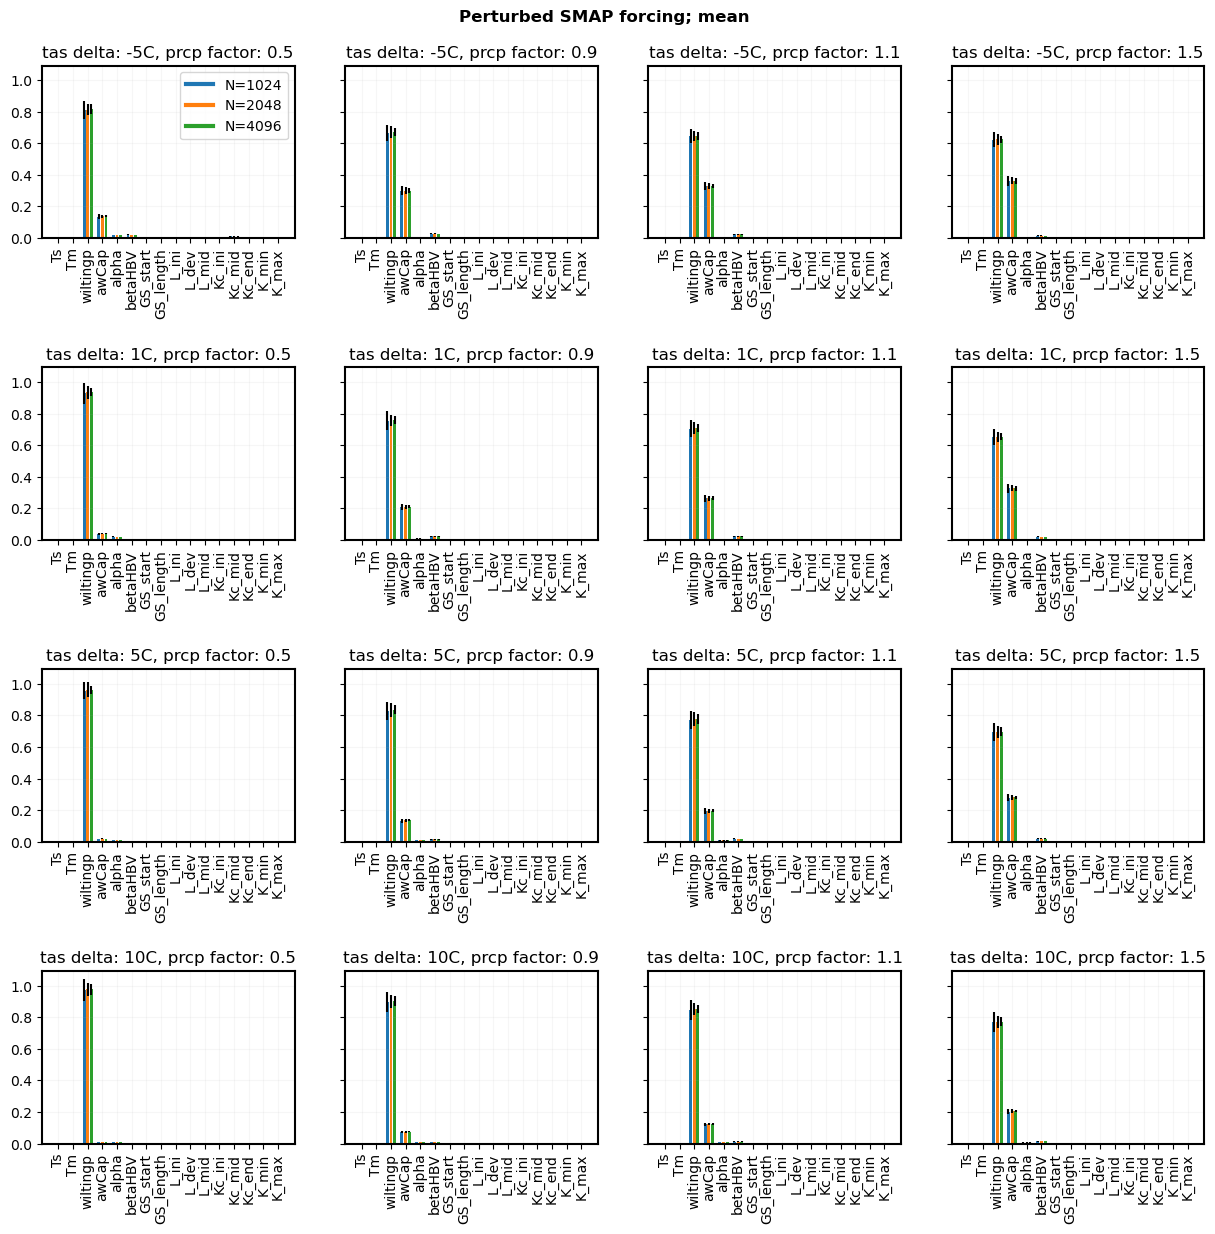

In [30]:
obs = "SMAP"
experiment = "champaign_IL_maize"
metric = "mean"

make_future_plot(obs, metric, experiment)

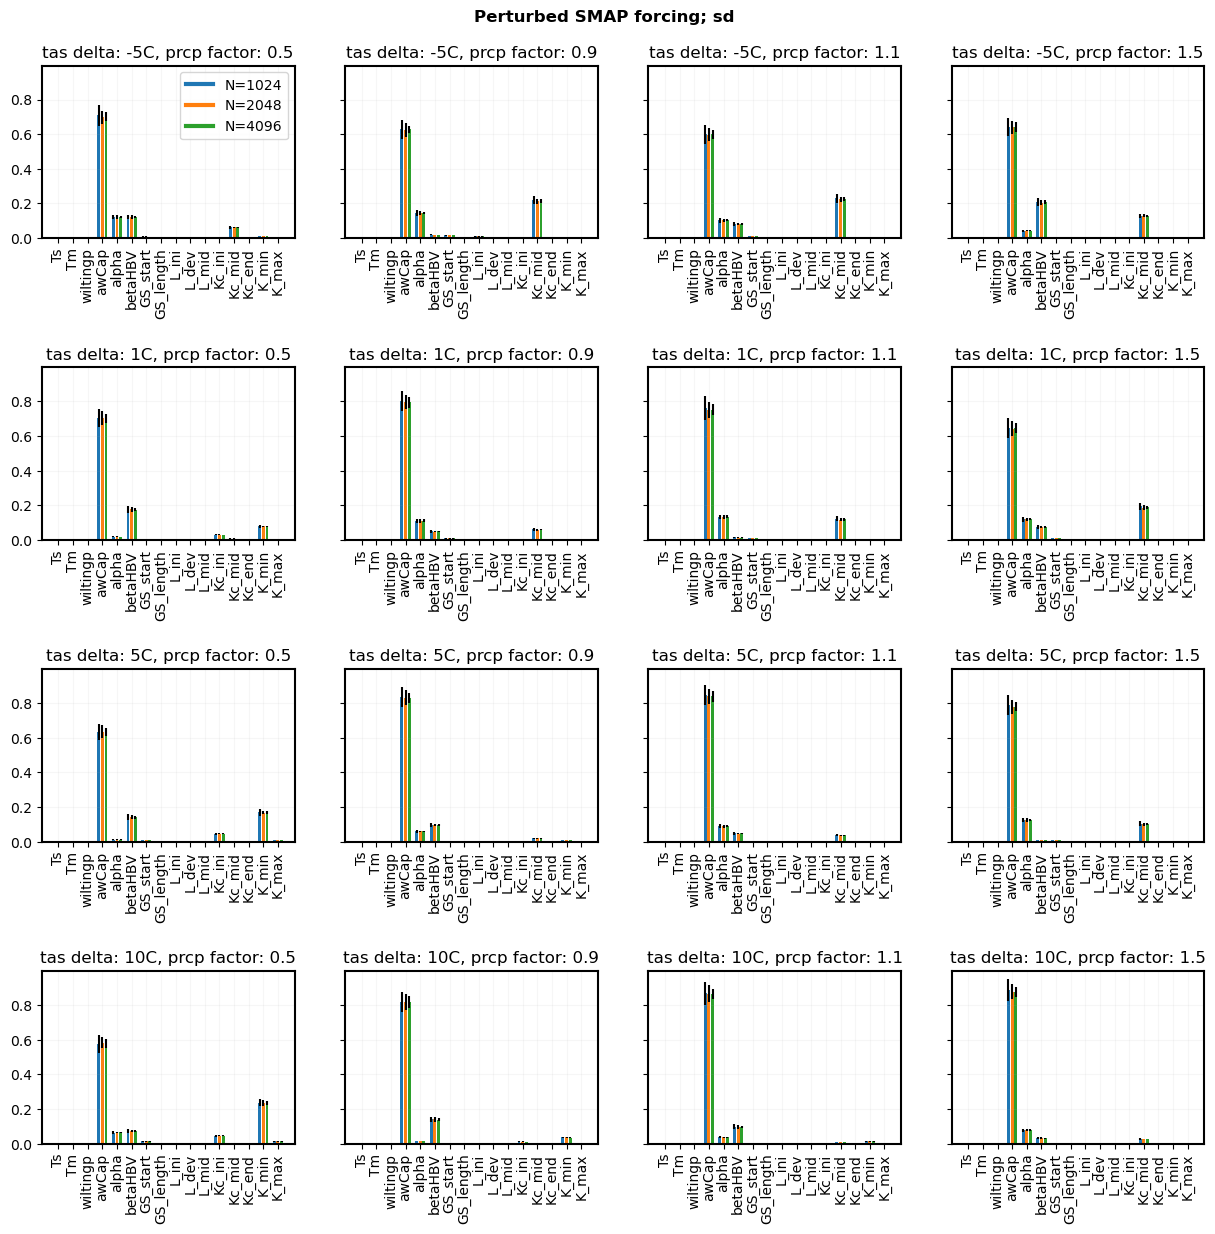

In [32]:
obs = "SMAP"
experiment = "champaign_IL_maize"
metric = "sd"

make_future_plot(obs, metric, experiment)

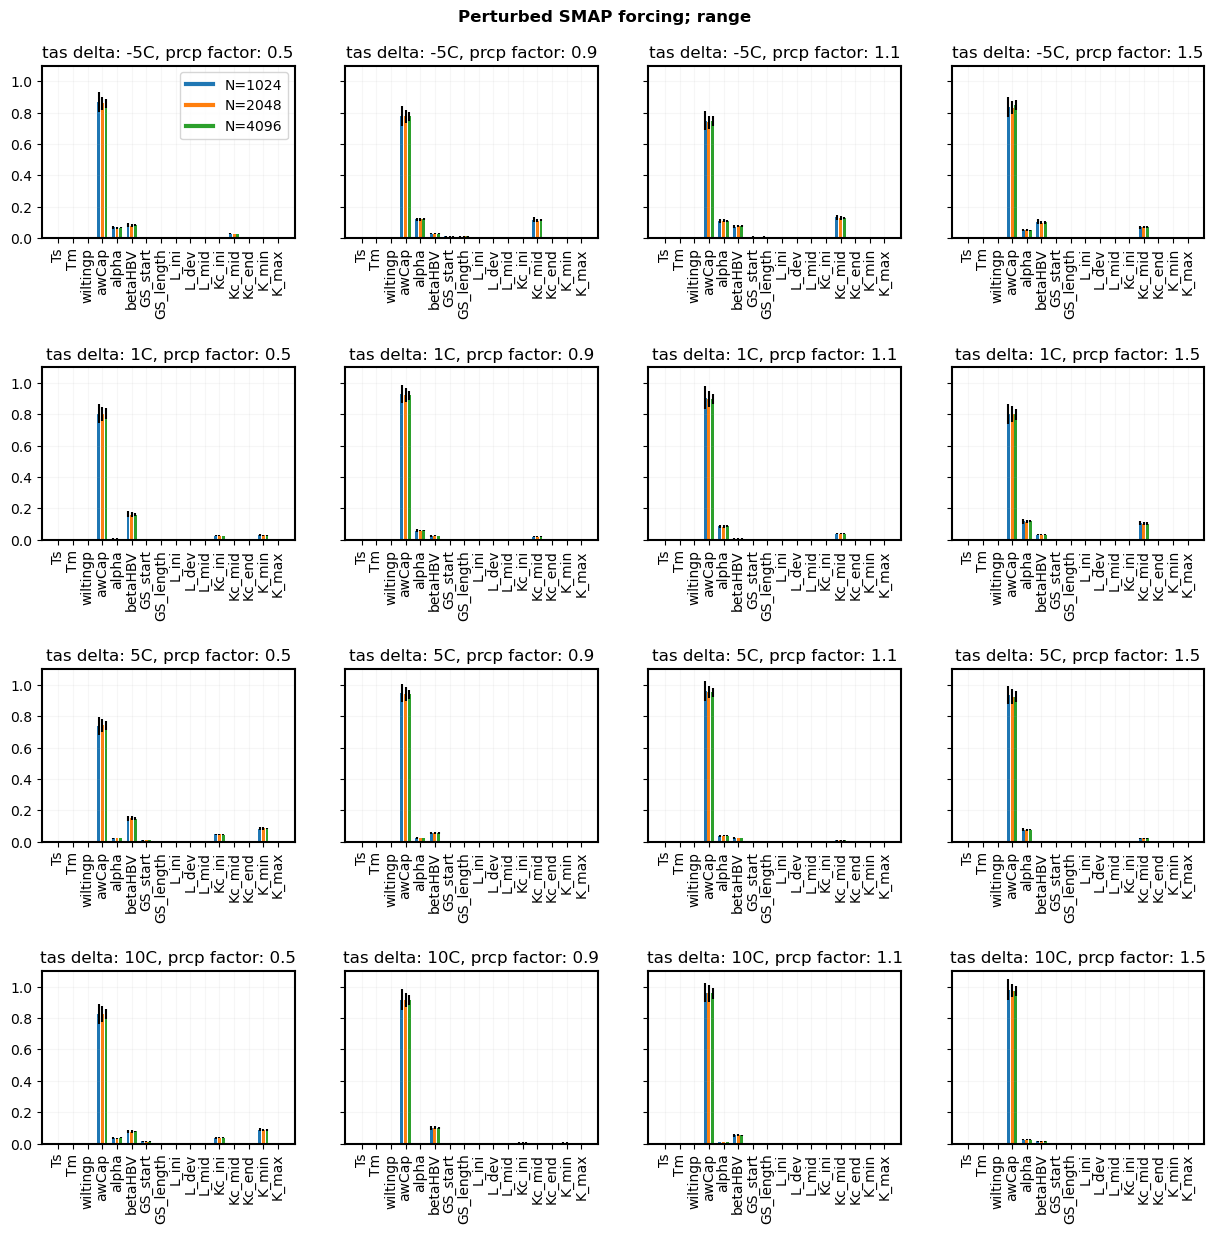

In [33]:
obs = "SMAP"
experiment = "champaign_IL_maize"
metric = "range"

make_future_plot(obs, metric, experiment)

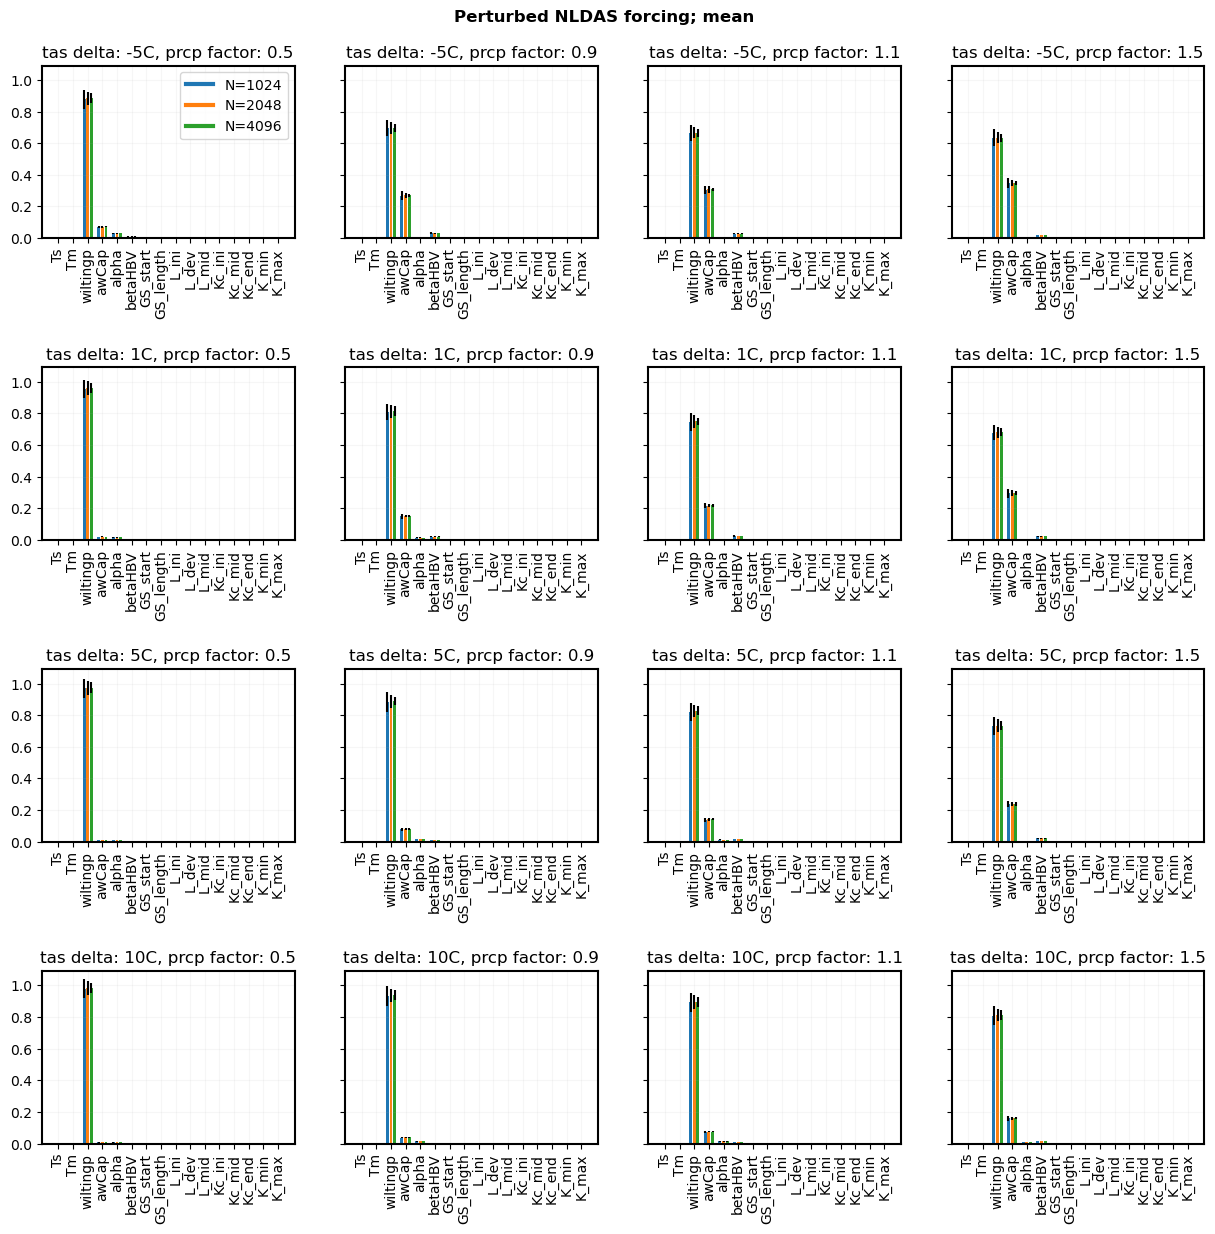

In [34]:
obs = "NLDAS"
experiment = "champaign_IL_maize"
metric = "mean"

make_future_plot(obs, metric, experiment)

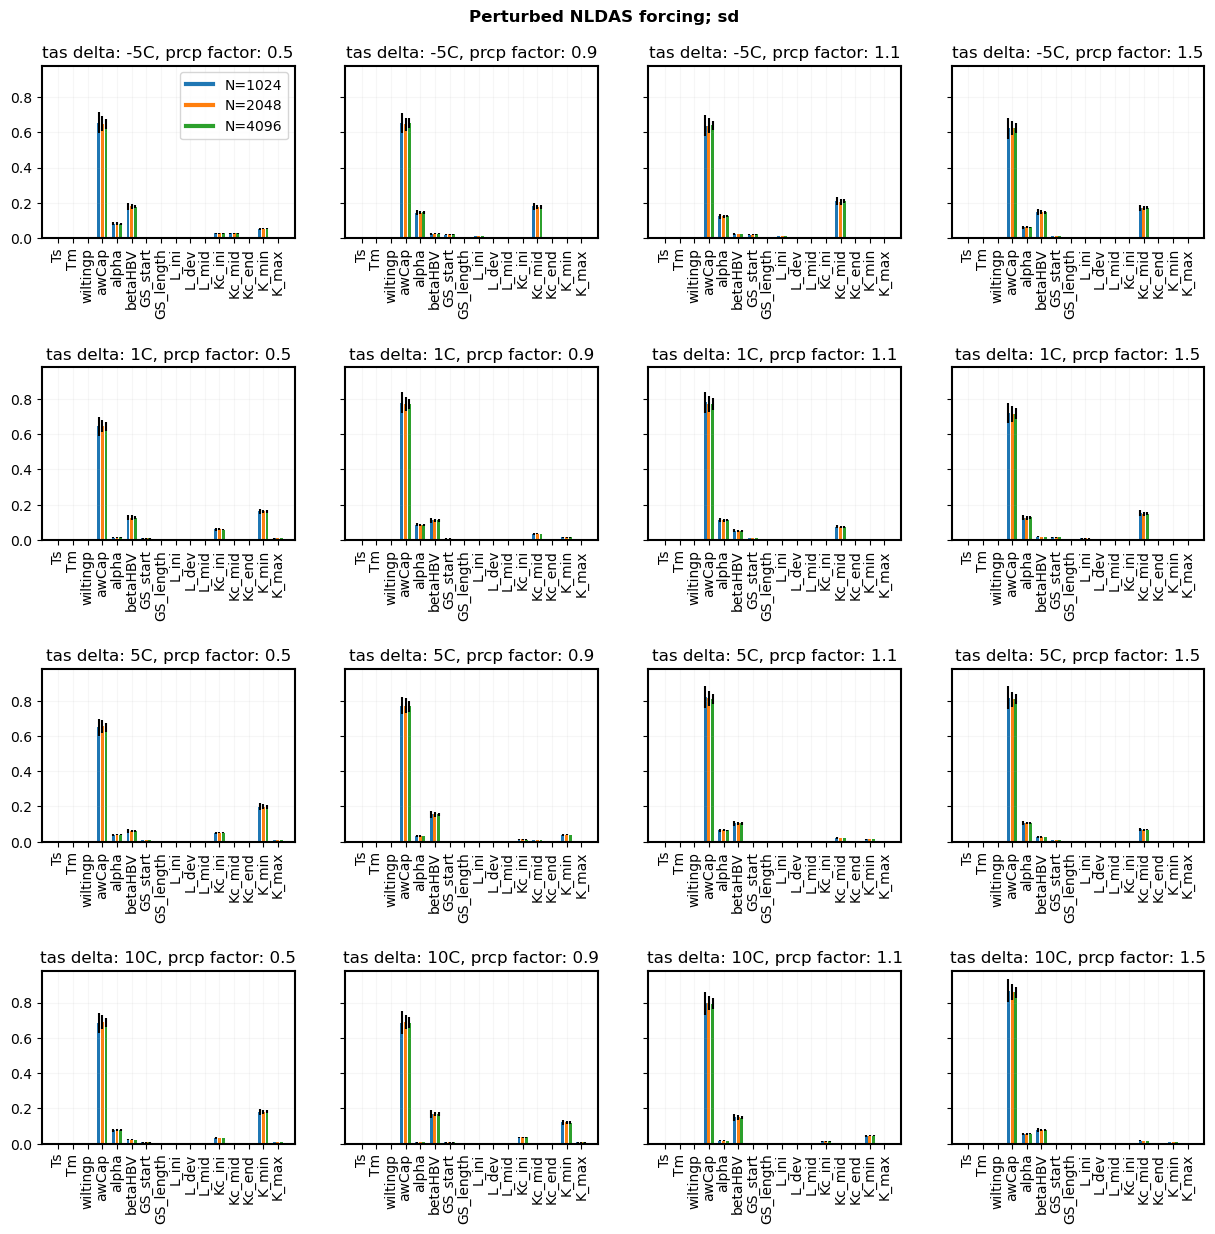

In [35]:
obs = "NLDAS"
experiment = "champaign_IL_maize"
metric = "sd"

make_future_plot(obs, metric, experiment)

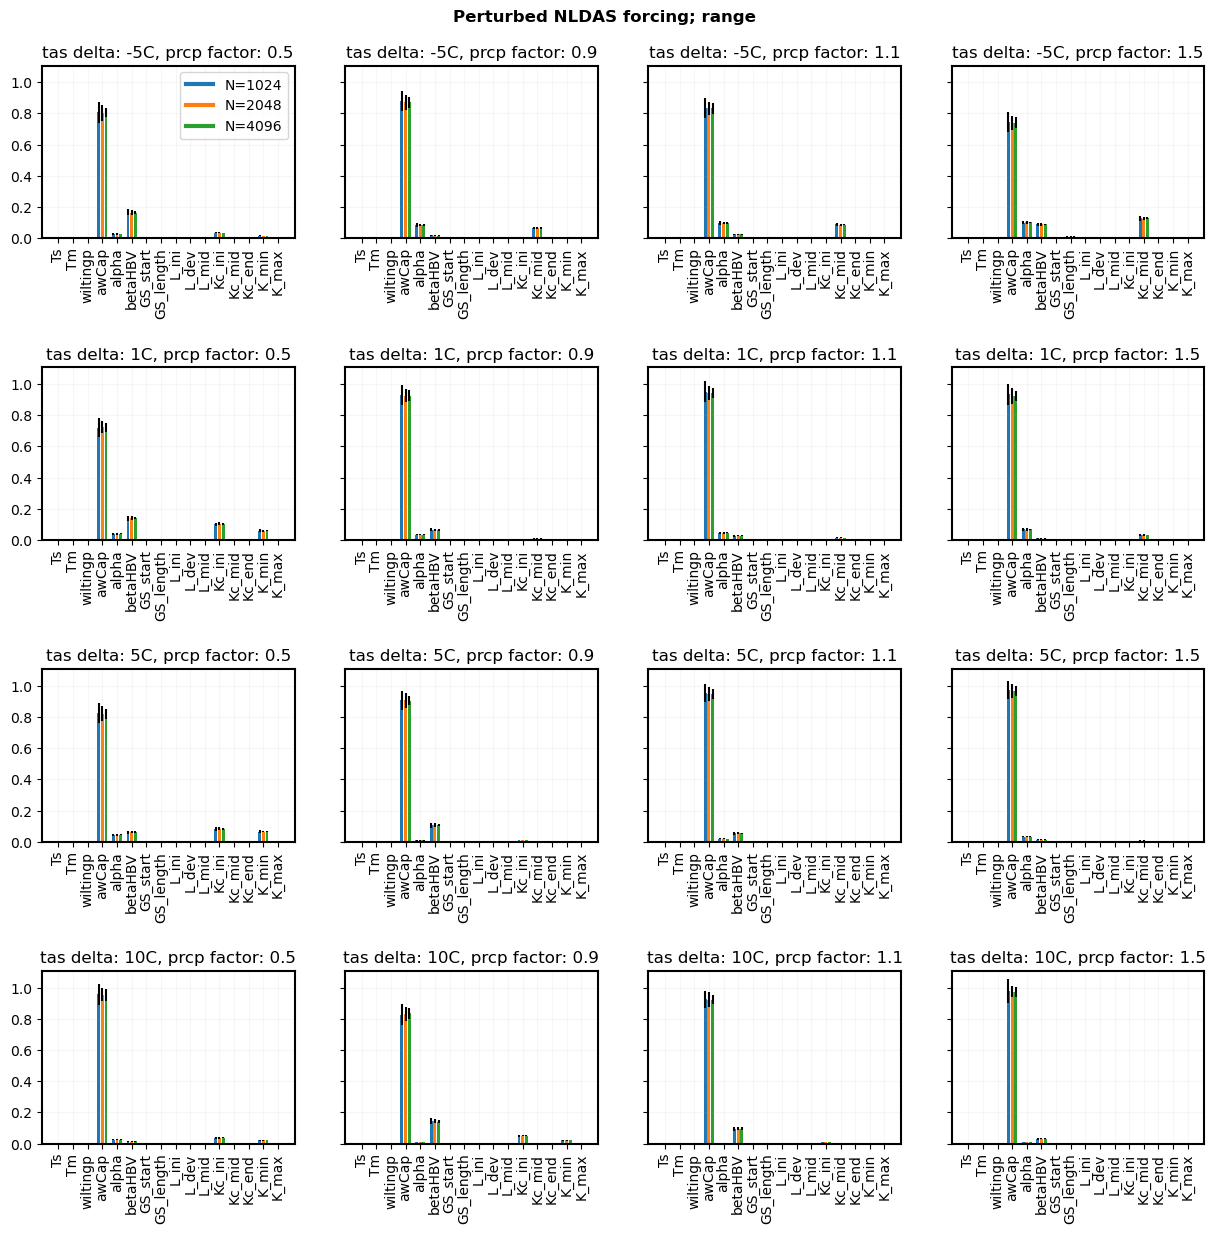

In [36]:
obs = "NLDAS"
experiment = "champaign_IL_maize"
metric = "range"

make_future_plot(obs, metric, experiment)